# Learning factors for stock market returns prediction

This notebook presents...
The project description is available [here](https://challengedata.ens.fr/participants/challenges/72/).


Contents
--------
1. [Introduction](#intro)
1. [Data loading and preprocessing](#loading)
2. [Exploratory data analysis](#eda)
3. [Missing data imputation](#imputation)
4. [Unregularized linear model](#linreg)
5. [Lasso-regularized linear model](#lasso_linreg)
6. [Conclusion](#conclusion)

## <a id="intro"></a> Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import LinearRegression, Lasso

## <a id="loading"></a> Data loading and preprocessing

In [ ]:
stock_returns = np.loadtxt('./X_train_YG7NZSq.csv', delimiter=',', skiprows=1)[:, 1:]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,118,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,2011-04-23 04:28:28.474576384,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,2010-07-30 00:00:00,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000
50%,10.000000,2011-04-29 00:00:00,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000
75%,15.250000,2011-12-31 18:00:00,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000
std,6.124614,NaN,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428


## <a id="eda"></a> Exploratory data analysis

Nice


### Distribution of means and variance

we begin by getting insights about seasonality effet and time variation of some features. Our two features of interest here are the consumer price index (CPI) and the temperature, which indirectly provide information about the store locations.

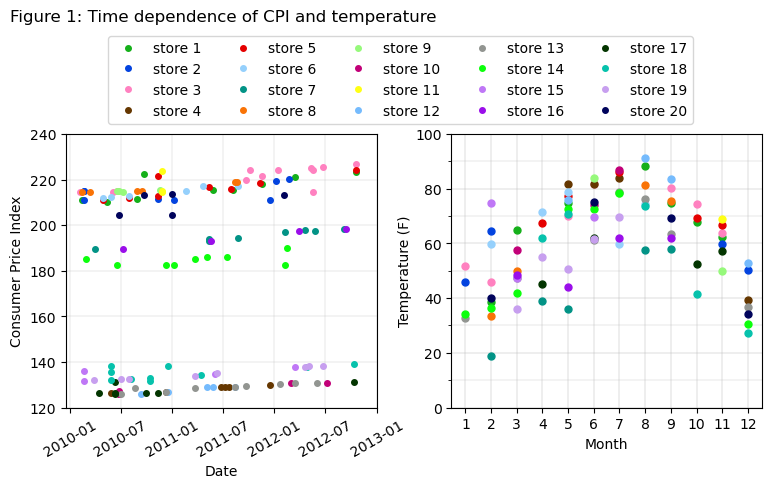

In [ ]:
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, sharey=False, figsize=(5.4, 4.), dpi=100,
    gridspec_kw={'left': 0.15, 'right': 0.96, 'top': 0.88, 'bottom': 0.13, 'wspace': 0.24})
fig1.suptitle("Figure 1: Returns mean and standard deviation",
              x=0.02, ha='left')

ax1.plot(np.mean(stock_returns, axis=1), np.std(stock_returns, axis=1),
         linestyle='', marker='o', markersize=4)

ax1.set_xlim(-0.0016, 0.0016)
ax1.set_xlabel('Average daily return', labelpad=6)
ax1.set_ylim(0, 0.03)
ax1.set_ylabel('Std deviation of daily returns', labelpad=7)
ax1.grid(visible=True, linewidth=0.3)


plt.show()

The daily returns are centered: the mean has probably been substracted to the original values.

### Evolution of the stock returns

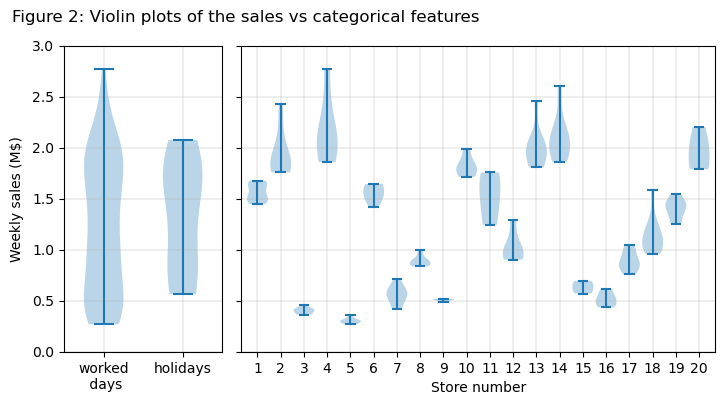

In [ ]:
COLORS = [
    '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000',
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#ffff14',
    '#75bbfd', '#929591', '#0cff0c', '#bf77f6', '#9a0eea', '#033500',
    '#06c2ac', '#c79fef', '#00035b', '#d1b26f', '#00ffff', '#06470c',
    ]


fig2, axs2 = plt.subplots(
    nrows=1, ncols=2, sharey=False, figsize=(8, 3.8), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.97, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.28})
fig2.suptitle("Figure 2: Evolution of stock returns",
              x=0.02, ha='left')

# Returns
for i, sr in enumerate(stock_returns):
    axs2[0].plot(sr, linewidth=0.8, color=COLORS[(i+2)%24])

axs2[0].set_xlim(0, 800)
axs2[0].set_xlabel('Date (days)')
axs2[0].set_ylim(-0.25, 0.25)
axs2[0].set_yticks([-0.15, -0.05, 0.05, 0.15], minor=True)
axs2[0].set_ylabel('Daily return')
axs2[0].grid(visible=True, linewidth=0.3)
axs2[0].grid(visible=True, which='minor', linewidth=0.2)

# Cummulative returns
for i, sr in enumerate(np.cumsum(stock_returns, axis=1)):
    axs2[1].plot(sr, linewidth=0.7, color=COLORS[(i+2)%24])

axs2[1].set_xlim(0, 800)
axs2[1].set_xlabel('Date (days)')
axs2[1].set_ylim(-1.25, 1.25)
axs2[1].set_yticks([-1.25, -0.75, -0.25, 0.25, 0.75, 1.25], minor=True)
axs2[1].set_ylabel('Cummulative return')
axs2[1].grid(visible=True, linewidth=0.3)
axs2[1].grid(visible=True, which='minor', linewidth=0.2)


plt.show()

Most valmues are between -0.05 and 0.05. We also note the presence of extreme events with
very large returns (about $10\sigma$, which is virtually impossible for gaussian processes).

### Dependence of the returns on the week day

In [ ]:
k = 5
returns_std = np.std(stock_returns, axis=1)
returns_mod = [X[:, i::k] for i in range(k)]

day_means = [np.mean(np.mean(x, axis=1) / returns_std) for x in returns_mod]
day_stds = [np.mean(np.std(x, axis=1) / returns_std) for x in returns_mod]

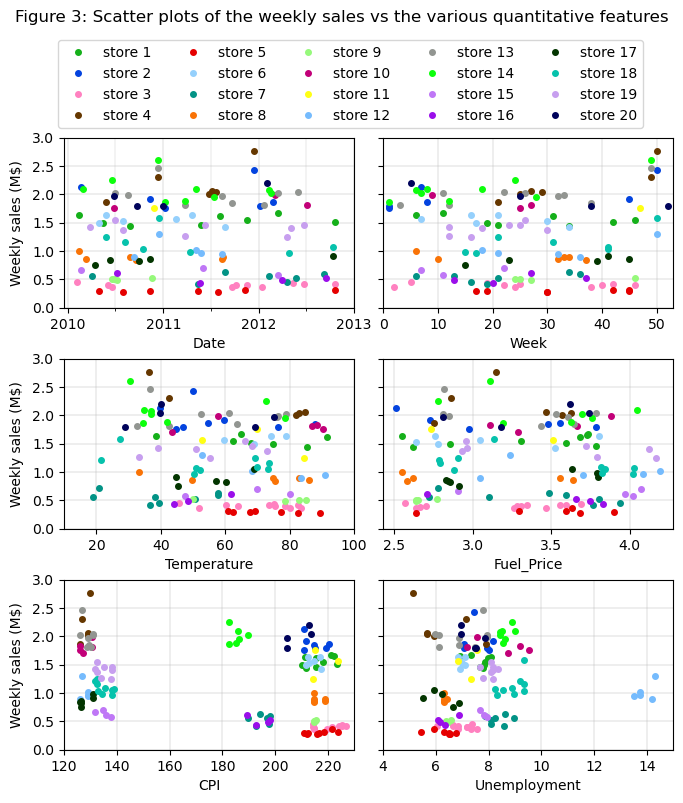

In [ ]:
fig3, ax3 = plt.subplots(
    nrows=1, ncols=1, sharey=True, figsize=(5.4, 3.8), dpi=100,
    gridspec_kw={'left': 0.16, 'right': 0.84, 'top': 0.89, 'bottom': 0.125})
fig3.suptitle("Figure 3: week day dependence of returns",
              x=0.02, ha='left')

# day means
l_mean, = ax3.plot(day_means, linestyle='', marker='o')
ax3.set_xlim(-0.5, 4.5)
ax3.set_xlabel('Day')
ax3.set_ylim(-0.03, 0.03)
# ax3.set_yticks([-0.15, -0.05, 0.05, 0.15], minor=True)
ax3.set_ylabel('Scaled mean return')
ax3.grid(visible=True, axis='y', linewidth=0.3)

# day std deviations
ax3_twin = ax3.twinx()
l_std, = ax3_twin.plot(day_stds, linestyle='', marker='o', color='tab:orange')
ax3_twin.set_xlim(-0.5, 4.5)
ax3_twin.set_xlabel('Day')
ax3_twin.set_ylim(0.97, 1.03)
ax3_twin.set_ylabel('Scaled return std deviation', labelpad=8)


fig3.legend(handles=[l_mean, l_std],
            labels=['mean returns', 'std. dev. of returns'],
            ncols=1, loc=(0.495, 0.755), alignment='center')

plt.show()

No effect

## <a id="iter_search"></a> An iterative approach

### Finding one vector

### Finding the other vectors

### Model interpretation

### Model evaluation

## <a id="lagrange"></a>Dual formulation



## <a id="conclusion"></a> Conclusion

We conclude by comparing the results for both unregularized and regularized linear regressions.

The values are actually very similar for both models. The regularized model has 4 coefficients out of 28 set to zero, which makes it slightly simpler yet clearly not sparse. It must be stressed out however that this gain was not free: it came with an additional computational cost.